In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json
/kaggle/input/sarcasm-corpus-v2oraby-et-al/RQ-sarc-notsarc.csv
/kaggle/input/sarcasm-corpus-v2oraby-et-al/GEN-sarc-notsarc.csv
/kaggle/input/sarcasm-corpus-v2oraby-et-al/HYP-sarc-notsarc.csv
/kaggle/input/sarcasm/train-balanced-sarc.csv.gz
/kaggle/input/sarcasm/train-balanced-sarcasm.csv
/kaggle/input/sarcasm/test-balanced.csv
/kaggle/input/sarcasm/test-unbalanced.csv


Number of available GPUs: 2
GPU 0: Tesla T4
GPU 1: Tesla T4
Step 1: Loading and preprocessing data from multiple datasets...
Loading Reddit Sarcasm dataset...
Added 15000 samples from Reddit dataset
Loading News Headlines dataset...
Added 15000 samples from Headlines dataset
Total combined dataset size: 30000
Training set size: 21000
Validation set size: 4500
Test set size: 4500
Step 2: Preparing BERT tokenizer and datasets...
Step 3: Initializing and training BERT+LSTM model with multi-GPU support...
Using device: cuda
Using 2 GPUs for training
Epoch 1/7 | Loss: 0.5114 | Train Acc: 0.7393 | Val Acc: 0.7796
Epoch 2/7 | Loss: 0.3438 | Train Acc: 0.8477 | Val Acc: 0.8018
Epoch 3/7 | Loss: 0.2187 | Train Acc: 0.9116 | Val Acc: 0.7909
Epoch 4/7 | Loss: 0.1215 | Train Acc: 0.9553 | Val Acc: 0.7918
Epoch 5/7 | Loss: 0.0757 | Train Acc: 0.9733 | Val Acc: 0.7871
Epoch 6/7 | Loss: 0.0504 | Train Acc: 0.9829 | Val Acc: 0.7880
Epoch 7/7 | Loss: 0.0364 | Train Acc: 0.9877 | Val Acc: 0.7873
Step 4:

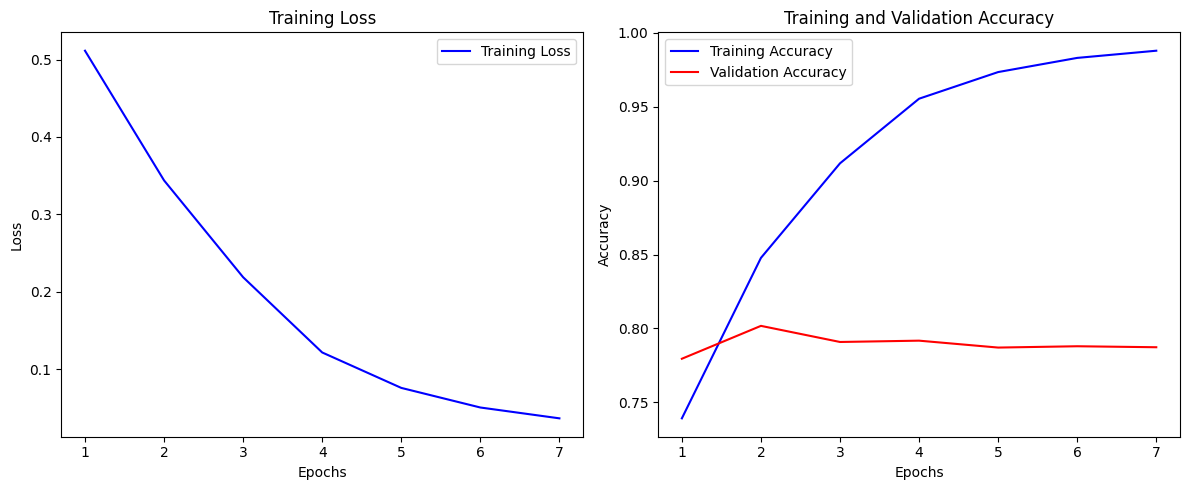

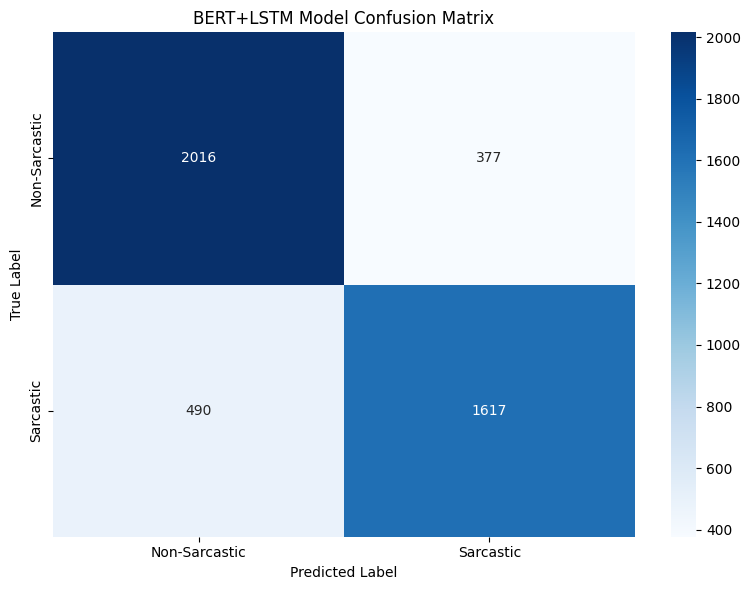


BERT+LSTM Sarcasm Detection Workflow Completed!

Sample Predictions:
Text: 'I just love waiting in long lines at the grocery store.'
Prediction: Non-sarcastic (Confidence: 0.9973)
--------------------------------------------------
Text: 'This movie was actually really good, I enjoyed it a lot.'
Prediction: Non-sarcastic (Confidence: 0.9994)
--------------------------------------------------
Text: 'Oh great, another meeting that could have been an email.'
Prediction: Sarcastic (Confidence: 0.9903)
--------------------------------------------------
Text: 'The weather today is beautiful and sunny.'
Prediction: Non-sarcastic (Confidence: 0.9992)
--------------------------------------------------
Text: 'Scientists discover breakthrough cancer treatment that only works on mice with perfect hair.'
Prediction: Non-sarcastic (Confidence: 0.9441)
--------------------------------------------------
Text: 'I'm thrilled that my flight was delayed by 5 hours.'
Prediction: Non-sarcastic (Confidence: 

In [6]:
import pandas as pd
import numpy as np
import json
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check available GPUs
print(f"Number of available GPUs: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# Define BERT+LSTM Sarcasm Detection Model
class BERTLSTMSarcasmDetector(nn.Module):
    def __init__(self, bert_model='bert-base-uncased', lstm_hidden_size=256, dropout_rate=0.3):
        super(BERTLSTMSarcasmDetector, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.lstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=lstm_hidden_size,
            bidirectional=True,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_size*2, 128),  # *2 for bidirectional
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 2)
        )
    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get all hidden states (sequence output)
        sequence_output = bert_outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        
        # Pass through LSTM
        lstm_output, _ = self.lstm(sequence_output)  # [batch_size, seq_len, hidden_size*2]
        
        # Get the final hidden state (you could also use attention here)
        lstm_final = lstm_output[:, -1, :]  # [batch_size, hidden_size*2]
        
        # Classifier
        x = self.dropout(lstm_final)
        logits = self.classifier(x)
        
        return logits

# Custom Dataset for Sarcasm data (same as before)
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Function to train the BERT+LSTM model
def train_bert_lstm_model(model, train_loader, val_loader, device, learning_rate=2e-5, epochs=15):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # For tracking metrics
    train_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = val_correct / val_total
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}')
    
    return train_losses, train_accs, val_accs, model

# Function to make predictions with BERT+LSTM
def predict_with_bert_lstm(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Modified main workflow function for BERT+LSTM
def bert_lstm_sarcasm_detection(dataset_paths, epochs=15, batch_size=32, sample_size_per_dataset=2500):
    # 1. Load and preprocess data from multiple datasets
    print("Step 1: Loading and preprocessing data from multiple datasets...")
    
    try:
        all_texts, all_labels = load_multiple_datasets(dataset_paths, sample_size_per_dataset)
        
        # Split combined data into train, validation, and test sets
        X_train, X_temp, y_train, y_temp = train_test_split(
            all_texts, all_labels, test_size=0.3, random_state=42, stratify=all_labels
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )
        
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Using sample data for demonstration")
        
        # Sample data for demonstration
        texts = [
            "I love waiting for hours at the DMV.",
            "This has been the best day ever!",
            "The weather is beautiful today.",
            "Sure, I'd love to work overtime on weekends.",
            "This phone has the best battery life I've ever seen.",
            "I couldn't be happier with this service.",
            "What a surprise, the train is late again.",
            "I'm so glad I spent all that money on this broken product.",
            "The customer service was excellent, very helpful.",
            "Absolutely fantastic, I waited 2 hours for this."
        ]
        labels = [1, 0, 0, 1, 0, 0, 1, 1, 0, 1]  # 1 for sarcastic, 0 for non-sarcastic
        
        X_train, X_temp, y_train, y_temp = train_test_split(
            texts, labels, test_size=0.4, random_state=42, stratify=labels
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )
    
    print(f"Training set size: {len(X_train)}")
    print(f"Validation set size: {len(X_val)}")
    print(f"Test set size: {len(X_test)}")
    
    # 2. Prepare BERT tokenizer and datasets
    print("Step 2: Preparing BERT tokenizer and datasets...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    train_dataset = SarcasmDataset(X_train, y_train, tokenizer)
    val_dataset = SarcasmDataset(X_val, y_val, tokenizer)
    test_dataset = SarcasmDataset(X_test, y_test, tokenizer)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # 3. Initialize and train BERT+LSTM model with multi-GPU support
    print("Step 3: Initializing and training BERT+LSTM model with multi-GPU support...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    bert_lstm_model = BERTLSTMSarcasmDetector()
    
    # Use DataParallel to utilize multiple GPUs
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs for training")
        bert_lstm_model = nn.DataParallel(bert_lstm_model)
        
    bert_lstm_model.to(device)
    
    train_losses, train_accs, val_accs, trained_model = train_bert_lstm_model(
        bert_lstm_model, train_loader, val_loader, device, epochs=epochs
    )
    
    # 4. Make predictions with BERT+LSTM on test set
    print("Step 4: Making predictions with BERT+LSTM...")
    bert_lstm_preds, true_labels = predict_with_bert_lstm(trained_model, test_loader, device)
    
    # Calculate metrics for BERT+LSTM
    bert_lstm_accuracy = accuracy_score(true_labels, bert_lstm_preds)
    bert_lstm_precision = precision_score(true_labels, bert_lstm_preds, average='weighted')
    bert_lstm_recall = recall_score(true_labels, bert_lstm_preds, average='weighted')
    bert_lstm_f1 = f1_score(true_labels, bert_lstm_preds, average='weighted')
    
    print("\nBERT+LSTM Model Metrics:")
    print(f"Accuracy: {bert_lstm_accuracy:.4f}")
    print(f"Precision: {bert_lstm_precision:.4f}")
    print(f"Recall: {bert_lstm_recall:.4f}")
    print(f"F1 Score: {bert_lstm_f1:.4f}")
    
    # Plot metrics for BERT+LSTM
    plot_metrics(train_losses, train_accs, val_accs)
    plot_confusion_matrix(true_labels, bert_lstm_preds, "BERT+LSTM Model Confusion Matrix")
    
    print("\nBERT+LSTM Sarcasm Detection Workflow Completed!")
    
    return {
        'bert_lstm_model': trained_model,
        'tokenizer': tokenizer,
        'device': device,
        'bert_lstm_metrics': {
            'accuracy': bert_lstm_accuracy,
            'precision': bert_lstm_precision,
            'recall': bert_lstm_recall,
            'f1': bert_lstm_f1
        }
    }

# Function to use the trained model for prediction
def predict_sarcasm(text, model, tokenizer, device):
    # Preprocess text
    encoding = tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Get BERT+LSTM prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        prob = probs[0][pred].item()
    
    result = "Sarcastic" if pred == 1 else "Non-sarcastic"
    
    return {
        "prediction": result, 
        "confidence": prob,
        "method": "BERT+LSTM"
    }

# Example usage
if __name__ == "__main__":
    # Paths to your dataset files
    dataset_paths = {
        'train-balanced-sarcasm.csv': '/kaggle/input/sarcasm/train-balanced-sarcasm.csv',
        'Sarcasm_Headlines_Dataset.json': '/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json',
        'GEN-sarc-notsarc.csv': '/kaggle/input/sarcasm-corpus-v2oraby-et-al/GEN-sarc-notsarc.csv',
        'HYP-sarc-notsarc.csv': '/kaggle/input/sarcasm-corpus-v2oraby-et-al/HYP-sarc-notsarc.csv',
        'RQ-sarc-notsarc.csv': '/kaggle/input/sarcasm-corpus-v2oraby-et-al/RQ-sarc-notsarc.csv'
    }
    
    # Run the BERT+LSTM workflow
    results = bert_lstm_sarcasm_detection(
        dataset_paths=dataset_paths,
        epochs=7,
        batch_size=32,
        sample_size_per_dataset=15000
    )
    
    # After training, you can use the model to make predictions
    model = results['bert_lstm_model']
    tokenizer = results['tokenizer']
    device = results['device']
    
    sample_texts = [
        "I just love waiting in long lines at the grocery store.",
        "This movie was actually really good, I enjoyed it a lot.",
        "Oh great, another meeting that could have been an email.",
        "The weather today is beautiful and sunny.",
        "Scientists discover breakthrough cancer treatment that only works on mice with perfect hair.",
        "I'm thrilled that my flight was delayed by 5 hours.",
        "Nothing brightens my day like stepping in a puddle with new shoes.",
        "Breaking news: Man realizes he forgot his phone after reaching office, world continues to exist."
    ]
    
    print("\nSample Predictions:")
    for text in sample_texts:
        result = predict_sarcasm(text, model, tokenizer, device)
        print(f"Text: '{text}'")
        print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.4f})")
        print("-" * 50)